# This notebook makes tables and figures

## Imports, configuration, and functions

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
font = {'family' : 'Arial',
        'size'   : 9}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
# InsectWingbeat and PenDigits are too large to efficiently compute, and thus are excluded

human_activity_datasets = ['BasicMotions', 'Cricket', 'Epilepsy', 'ERing', 'Handwriting', 'Libras', 'NATOPS', 'RacketSports', 'UWaveGestureLibrary']
motion_datasets = ['ArticularyWordRecognition', 'CharacterTrajectories', 'EigenWorms']
ecg_datasets = ['AtrialFibrillation', 'StandWalkJump']
eeg_meg_datasets = ['FingerMovements', 'MotorImagery', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'FaceDetection', 'HandMovementDirection']
audio_spectra_datasets = ['DuckDuckGeese', 'Heartbeat', 'PhonemeSpectra', 'SpokenArabicDigits', 'JapaneseVowels']
other_spatial_datasets = ['PEMS-SF', 'LSST']
other_nonspatial_datasets = ['EthanolConcentration']

spatial_datasets = human_activity_datasets + motion_datasets+other_spatial_datasets
non_spatial_datasets = ecg_datasets + eeg_meg_datasets + audio_spectra_datasets + other_nonspatial_datasets
print(f'There are {len(spatial_datasets)} spatial datasets and {len(non_spatial_datasets)} non-spatial datasets.')

model_types = ['TS2Vec', 'Topo-TS2Vec', 'GGeo-TS2Vec', 'SoftCLT', 'Topo-SoftCLT', 'GGeo-SoftCLT']

There are 14 spatial datasets and 14 non-spatial datasets.


In [3]:
def light_color(color, alpha=0.5):
    if isinstance(color, str):
        color = mpl.colors.to_rgb(color)
    return tuple([c + (1 - c) * (1 - alpha) for c in color])
    

def highlight_col(col, highlight_type='max', scientific_notation=False, involve_second=True):
    if np.mean(col)>0.01:
        col = np.round(col.values, 3)
    else:
        col = col.values
    
    if highlight_type == 'none':
        sorted_col = np.zeros_like(col)*np.nan
    elif highlight_type == 'max':
        sorted_col = np.sort(col[~np.isnan(col)])[::-1]
    elif highlight_type == 'min':
        sorted_col = np.sort(col[~np.isnan(col)])
    else:
        raise ValueError("highlight_type must be 'none' 'max' or 'min'.")
    is_extreme = col==sorted_col[0]
    is_second_extreme = col==sorted_col[1]
    
    styled_col = []
    if scientific_notation and np.mean(col)<=0.01:
        for i, v in enumerate(col):
            if is_extreme[i]:
                styled_col.append(f'\\textbf{{\\underline{{{v:.3E}}}}}'.replace('E-0','E-'))
            elif is_second_extreme[i] and involve_second:
                styled_col.append(f'\\textbf{{{v:.3E}}}'.replace('E-0','E-'))
            else:
                styled_col.append(f'{v:.3E}'.replace('E-0','E-'))
    else:
        for i, v in enumerate(col):
            if is_extreme[i]:
                styled_col.append(f'\\textbf{{\\underline{{{v:.3f}}}}}')
            elif is_second_extreme[i] and involve_second:
                styled_col.append(f'\\textbf{{{v:.3f}}}')
            else:
                styled_col.append(f'{v:.3f}')
    return styled_col


def highlight(df, max_cols=[], min_cols=[], scientific_notation=False, involve_second=True):
    if len(max_cols)==0 and len(min_cols)==0:
        for col in df.columns:
            df[col] = highlight_col(df[col], 'none', scientific_notation, involve_second)
    else:
        for col in max_cols:
            df[col] = highlight_col(df[col], 'max', scientific_notation, involve_second)
        for col in min_cols:
            df[col] = highlight_col(df[col], 'min', scientific_notation, involve_second)
    return df

def to_grayscale(fig):
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    grayscale_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
    fig_gray, ax_gray = plt.subplots(figsize=(fig.get_size_inches()), dpi=fig.dpi)
    ax_gray.imshow(grayscale_img, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    ax_gray.axis('off')  # Turn off the axis
    ax_gray.set_title('Grayscale plot')

## UEA classification

In [5]:
eval_uea = pd.read_csv(f'../results/evaluation/UEA_evaluation.csv', index_col=[0, 1])
eval_uea = eval_uea.T.iloc[:-1].astype(float).T
eval_uea = eval_uea.rename(index={'ts2vec':'TS2Vec', 'topo-ts2vec':'Topo-TS2Vec', 'ggeo-ts2vec':'GGeo-TS2Vec', 
                                  'softclt':'SoftCLT', 'topo-softclt':'Topo-SoftCLT', 'ggeo-softclt':'GGeo-SoftCLT'})

clf_cls_loss_metrics = ['svm_acc','svm_auprc','scl_loss','sp_loss']
dist_metrics = ['mean_shared_neighbours','mean_continuity','mean_trustworthiness','mean_dist_mrre','distmat_rmse']

model_types = ['TS2Vec', 'Topo-TS2Vec', 'GGeo-TS2Vec', 'SoftCLT', 'Topo-SoftCLT', 'GGeo-SoftCLT']

### Task-specific metrics

In [6]:
# Spatial datasets
avg_uea = eval_uea[eval_uea.index.get_level_values(1).isin(spatial_datasets)].copy()
avg_uea = avg_uea.groupby(level=0)[clf_cls_loss_metrics].mean().loc[model_types]
styled_uea = highlight(avg_uea, max_cols=clf_cls_loss_metrics[:2])
styled_uea = styled_uea.style.format(decimal='.', thousands=',', precision=3)
print(styled_uea.to_latex())
styled_uea

\begin{tabular}{lllrr}
 & svm_acc & svm_auprc & scl_loss & sp_loss \\
model &  &  &  &  \\
TS2Vec & 0.848 & 0.872 & 2.943 & nan \\
Topo-TS2Vec & 0.851 & 0.876 & 2.264 & 0.085 \\
GGeo-TS2Vec & 0.856 & 0.881 & 2.200 & 186.921 \\
SoftCLT & 0.852 & 0.876 & 7.943 & nan \\
Topo-SoftCLT & \textbf{0.862} & \textbf{0.882} & 4.900 & 0.087 \\
GGeo-SoftCLT & \textbf{\underline{0.864}} & \textbf{\underline{0.883}} & 2.316 & 221.105 \\
\end{tabular}



,svm_acc,svm_auprc,scl_loss,sp_loss
model,,,,
TS2Vec,0.848,0.872,2.943,nan
Topo-TS2Vec,0.851,0.876,2.264,0.085
GGeo-TS2Vec,0.856,0.881,2.200,186.921
SoftCLT,0.852,0.876,7.943,nan
Topo-SoftCLT,\textbf{0.862},\textbf{0.882},4.900,0.087
GGeo-SoftCLT,\textbf{\underline{0.864}},\textbf{\underline{0.883}},2.316,221.105


In [7]:
# Non-spatial datasets
avg_uea = eval_uea[eval_uea.index.get_level_values(1).isin(non_spatial_datasets)].copy()
avg_uea = avg_uea.groupby(level=0)[clf_cls_loss_metrics].mean().loc[model_types]
avg_uea = np.round(avg_uea, 3)
styled_uea = highlight(avg_uea, max_cols=clf_cls_loss_metrics[:2])
styled_uea = styled_uea.style.format(decimal='.', thousands=',', precision=3)
print(styled_uea.to_latex())
styled_uea

\begin{tabular}{lllrr}
 & svm_acc & svm_auprc & scl_loss & sp_loss \\
model &  &  &  &  \\
TS2Vec & 0.523 & 0.555 & 8.417 & nan \\
Topo-TS2Vec & \textbf{\underline{0.553}} & \textbf{0.561} & 11.124 & 0.122 \\
GGeo-TS2Vec & 0.536 & \textbf{\underline{0.564}} & 15.578 & 957.028 \\
SoftCLT & 0.508 & 0.532 & 4.714 & nan \\
Topo-SoftCLT & 0.496 & 0.534 & 7.328 & 0.124 \\
GGeo-SoftCLT & \textbf{0.537} & 0.549 & 10.085 & 144.769 \\
\end{tabular}



,svm_acc,svm_auprc,scl_loss,sp_loss
model,,,,
TS2Vec,0.523,0.555,8.417,nan
Topo-TS2Vec,\textbf{\underline{0.553}},\textbf{0.561},11.124,0.122
GGeo-TS2Vec,0.536,\textbf{\underline{0.564}},15.578,957.028
SoftCLT,0.508,0.532,4.714,nan
Topo-SoftCLT,0.496,0.534,7.328,0.124
GGeo-SoftCLT,\textbf{0.537},0.549,10.085,144.769


### Task-specific improvements

In [8]:
# Spatial datasets
improvement = eval_uea[eval_uea.index.get_level_values(1).isin(spatial_datasets)].copy()
metrics = ['svm_acc']
for metric in metrics:
    for method in model_types:
        if 'TS2Vec' in method and method!='TS2Vec':
            new_values = improvement.loc[method, metric].values
            old_values = improvement.loc['TS2Vec', metric].values
            improvement.loc[method, 'improvement_'+metric] = (new_values - old_values)/old_values*100
        elif 'SoftCLT' in method and method!='SoftCLT':
            new_values = improvement.loc[method, metric].values
            old_values = improvement.loc['SoftCLT', metric].values
            improvement.loc[method, 'improvement_'+metric] = (new_values - old_values)/old_values*100

model_types = ['Topo-TS2Vec', 'GGeo-TS2Vec', 'Topo-SoftCLT', 'GGeo-SoftCLT']
min_max_improvement = improvement.groupby(level=0)[['improvement_'+metric for metric in metrics]].agg(['min','mean','max']).loc[model_types]
min_max_improvement = min_max_improvement.style.format(decimal='.', thousands=',', precision=3)

print(min_max_improvement.to_latex())
for model in model_types:
    print('max', model+':', improvement.loc[model, 'improvement_svm_acc'].idxmax())
min_max_improvement

\begin{tabular}{lrrr}
 & \multicolumn{3}{r}{improvement_svm_acc} \\
 & min & mean & max \\
model &  &  &  \\
Topo-TS2Vec & -4.403 & 0.800 & 16.541 \\
GGeo-TS2Vec & -3.783 & 1.143 & 10.443 \\
Topo-SoftCLT & -4.375 & 2.121 & 25.943 \\
GGeo-SoftCLT & -5.674 & 2.959 & 28.546 \\
\end{tabular}

max Topo-TS2Vec: LSST
max GGeo-TS2Vec: LSST
max Topo-SoftCLT: LSST
max GGeo-SoftCLT: LSST


In [9]:
# Non-spatial datasets
improvement = eval_uea[eval_uea.index.get_level_values(1).isin(non_spatial_datasets)].copy()
metrics = ['svm_acc']
for metric in metrics:
    for method in model_types:
        if 'TS2Vec' in method and method!='TS2Vec':
            new_values = improvement.loc[method, metric].values
            old_values = improvement.loc['TS2Vec', metric].values
            improvement.loc[method, 'improvement_'+metric] = (new_values - old_values)/old_values*100
        elif 'SoftCLT' in method and method!='SoftCLT':
            new_values = improvement.loc[method, metric].values
            old_values = improvement.loc['SoftCLT', metric].values
            improvement.loc[method, 'improvement_'+metric] = (new_values - old_values)/old_values*100

model_types = ['Topo-TS2Vec', 'GGeo-TS2Vec', 'Topo-SoftCLT', 'GGeo-SoftCLT']
min_max_improvement = improvement.groupby(level=0)[['improvement_'+metric for metric in metrics]].agg(['min','mean','max']).loc[model_types]
min_max_improvement = min_max_improvement.style.format(decimal='.', thousands=',', precision=3)

print(min_max_improvement.to_latex())
for model in model_types:
    print('max', model+':', improvement.loc[model, 'improvement_svm_acc'].idxmax())
min_max_improvement

\begin{tabular}{lrrr}
 & \multicolumn{3}{r}{improvement_svm_acc} \\
 & min & mean & max \\
model &  &  &  \\
Topo-TS2Vec & -5.263 & 8.852 & 50.000 \\
GGeo-TS2Vec & -33.333 & 2.083 & 44.444 \\
Topo-SoftCLT & -33.333 & -0.815 & 50.000 \\
GGeo-SoftCLT & -20.833 & 18.496 & 166.667 \\
\end{tabular}

max Topo-TS2Vec: DuckDuckGeese
max GGeo-TS2Vec: DuckDuckGeese
max Topo-SoftCLT: AtrialFibrillation
max GGeo-SoftCLT: StandWalkJump


### Structure preservation metrics

In [10]:
local_dist_metrics = ['local_'+metric for metric in dist_metrics]
global_dist_metrics = ['global_'+metric for metric in dist_metrics]
model_types = ['TS2Vec', 'Topo-TS2Vec', 'GGeo-TS2Vec', 'SoftCLT', 'Topo-SoftCLT', 'GGeo-SoftCLT']

In [11]:
# Spatial datasets
local_uea = eval_uea[eval_uea.index.get_level_values(1).isin(spatial_datasets)].copy()
local_uea = local_uea.groupby(level=0)[local_dist_metrics].mean().loc[model_types]
local_uea = highlight(local_uea, max_cols=local_dist_metrics[:3], min_cols=local_dist_metrics[3:])

global_uea = eval_uea[eval_uea.index.get_level_values(1).isin(spatial_datasets)].copy()
global_uea = global_uea.groupby(level=0)[global_dist_metrics].mean().loc[model_types]
global_uea = highlight(global_uea, max_cols=global_dist_metrics[:3], min_cols=global_dist_metrics[3:])

avg_uea = local_uea.merge(global_uea, left_index=True, right_index=True, suffixes=('_local','_global'))
print(avg_uea.to_latex())
avg_uea

\begin{tabular}{lllllllllll}
\toprule
 & local_mean_shared_neighbours & local_mean_continuity & local_mean_trustworthiness & local_mean_dist_mrre & local_distmat_rmse & global_mean_shared_neighbours & global_mean_continuity & global_mean_trustworthiness & global_mean_dist_mrre & global_distmat_rmse \\
model &  &  &  &  &  &  &  &  &  &  \\
\midrule
TS2Vec & 0.563 & 0.868 & 0.875 & 0.117 & 0.346 & 0.419 & 0.784 & 0.765 & 0.189 & \textbf{0.150} \\
Topo-TS2Vec & \textbf{0.569} & \textbf{0.873} & 0.878 & \textbf{0.114} & 0.344 & 0.418 & 0.783 & 0.764 & 0.190 & 0.154 \\
GGeo-TS2Vec & \textbf{0.569} & \textbf{0.873} & \textbf{0.881} & \textbf{0.114} & \textbf{0.341} & 0.418 & 0.781 & 0.762 & 0.190 & 0.157 \\
SoftCLT & 0.562 & 0.866 & 0.875 & 0.117 & 0.348 & 0.420 & \textbf{0.788} & 0.765 & \textbf{0.187} & 0.171 \\
Topo-SoftCLT & 0.564 & 0.869 & 0.877 & 0.115 & 0.344 & \textbf{0.421} & 0.784 & \textbf{0.767} & 0.188 & 0.153 \\
GGeo-SoftCLT & \textbf{\underline{0.571}} & \textbf{\underline{0.

,local_mean_shared_neighbours,local_mean_continuity,local_mean_trustworthiness,local_mean_dist_mrre,local_distmat_rmse,global_mean_shared_neighbours,global_mean_continuity,global_mean_trustworthiness,global_mean_dist_mrre,global_distmat_rmse
model,,,,,,,,,,
TS2Vec,0.563,0.868,0.875,0.117,0.346,0.419,0.784,0.765,0.189,\textbf{0.150}
Topo-TS2Vec,\textbf{0.569},\textbf{0.873},0.878,\textbf{0.114},0.344,0.418,0.783,0.764,0.190,0.154
GGeo-TS2Vec,\textbf{0.569},\textbf{0.873},\textbf{0.881},\textbf{0.114},\textbf{0.341},0.418,0.781,0.762,0.190,0.157
SoftCLT,0.562,0.866,0.875,0.117,0.348,0.420,\textbf{0.788},0.765,\textbf{0.187},0.171
Topo-SoftCLT,0.564,0.869,0.877,0.115,0.344,\textbf{0.421},0.784,\textbf{0.767},0.188,0.153
GGeo-SoftCLT,\textbf{\underline{0.571}},\textbf{\underline{0.875}},\textbf{\underline{0.883}},\textbf{\underline{0.111}},\textbf{\underline{0.337}},\textbf{\underline{0.425}},\textbf{\underline{0.790}},\textbf{\underline{0.768}},\textbf{\underline{0.185}},\textbf{\underline{0.149}}


In [12]:
# Non-spatial datasets
local_uea = eval_uea[eval_uea.index.get_level_values(1).isin(non_spatial_datasets)].copy()
local_uea = local_uea.groupby(level=0)[local_dist_metrics].mean().loc[model_types]
local_uea = highlight(local_uea, max_cols=local_dist_metrics[:3], min_cols=local_dist_metrics[3:])

global_uea = eval_uea[eval_uea.index.get_level_values(1).isin(non_spatial_datasets)].copy()
global_uea = global_uea.groupby(level=0)[global_dist_metrics].mean().loc[model_types]
global_uea = highlight(global_uea, max_cols=global_dist_metrics[:3], min_cols=global_dist_metrics[3:])

avg_uea = local_uea.merge(global_uea, left_index=True, right_index=True, suffixes=('_local','_global'))
print(avg_uea.to_latex())
avg_uea

\begin{tabular}{lllllllllll}
\toprule
 & local_mean_shared_neighbours & local_mean_continuity & local_mean_trustworthiness & local_mean_dist_mrre & local_distmat_rmse & global_mean_shared_neighbours & global_mean_continuity & global_mean_trustworthiness & global_mean_dist_mrre & global_distmat_rmse \\
model &  &  &  &  &  &  &  &  &  &  \\
\midrule
TS2Vec & 0.423 & \textbf{0.820} & \textbf{\underline{0.835}} & 0.150 & \textbf{\underline{0.304}} & \textbf{0.362} & 0.767 & 0.767 & \textbf{\underline{0.252}} & 0.197 \\
Topo-TS2Vec & 0.424 & \textbf{0.820} & 0.831 & 0.151 & \textbf{0.308} & 0.356 & 0.763 & 0.767 & 0.254 & \textbf{0.191} \\
GGeo-TS2Vec & 0.420 & \textbf{0.820} & 0.832 & 0.151 & 0.310 & \textbf{\underline{0.365}} & \textbf{\underline{0.769}} & \textbf{\underline{0.771}} & 0.253 & \textbf{\underline{0.189}} \\
SoftCLT & \textbf{\underline{0.432}} & \textbf{0.820} & \textbf{\underline{0.835}} & \textbf{0.148} & 0.312 & 0.354 & 0.763 & 0.764 & \textbf{\underline{0.252}} & 0.197

,local_mean_shared_neighbours,local_mean_continuity,local_mean_trustworthiness,local_mean_dist_mrre,local_distmat_rmse,global_mean_shared_neighbours,global_mean_continuity,global_mean_trustworthiness,global_mean_dist_mrre,global_distmat_rmse
model,,,,,,,,,,
TS2Vec,0.423,\textbf{0.820},\textbf{\underline{0.835}},0.150,\textbf{\underline{0.304}},\textbf{0.362},0.767,0.767,\textbf{\underline{0.252}},0.197
Topo-TS2Vec,0.424,\textbf{0.820},0.831,0.151,\textbf{0.308},0.356,0.763,0.767,0.254,\textbf{0.191}
GGeo-TS2Vec,0.420,\textbf{0.820},0.832,0.151,0.310,\textbf{\underline{0.365}},\textbf{\underline{0.769}},\textbf{\underline{0.771}},0.253,\textbf{\underline{0.189}}
SoftCLT,\textbf{\underline{0.432}},\textbf{0.820},\textbf{\underline{0.835}},\textbf{0.148},0.312,0.354,0.763,0.764,\textbf{\underline{0.252}},0.197
Topo-SoftCLT,0.426,0.818,0.834,\textbf{0.148},0.312,0.361,\textbf{0.768},\textbf{0.768},0.254,0.205
GGeo-SoftCLT,\textbf{0.430},\textbf{\underline{0.822}},\textbf{\underline{0.835}},\textbf{\underline{0.147}},0.315,0.355,0.761,0.762,0.257,0.203


## Traffic prediction

In [13]:
macro_prediction_metrics = ['mae', 'rmse', 'error_std', 'explained_variance']
micro_prediction_metrics = ['min_fde', 'mr_05', 'mr_1', 'mr_2']
dist_metrics = ['mean_shared_neighbours','mean_continuity','mean_trustworthiness','mean_dist_mrre','distmat_rmse']
model_types = ['No pretraining', 'TS2Vec', 'Topo-TS2Vec', 'GGeo-TS2Vec', 'SoftCLT', 'Topo-SoftCLT', 'GGeo-SoftCLT']

In [22]:
eval_macro_continued = []
macro_progress = pd.read_csv(f'../results/evaluation/MacroTraffic_progress_evaluation.csv', index_col=[0])
for model in ['original','ts2vec','softclt','topo-ts2vec','ggeo-ts2vec','topo-softclt','ggeo-softclt']:
    eval_macro_continued.append((macro_progress.loc[model].iloc[[-1]]+macro_progress.loc[model].iloc[[-2]])/2)
eval_macro_continued = pd.concat(eval_macro_continued, axis=0)
eval_macro_continued = eval_macro_continued.T.iloc[1:].astype(float).T
eval_macro_continued = eval_macro_continued.rename(index={'original':'No pretraining', 'ts2vec':'TS2Vec', 'topo-ts2vec':'Topo-TS2Vec', 'ggeo-ts2vec':'GGeo-TS2Vec',
                                                          'softclt':'SoftCLT', 'topo-softclt':'Topo-SoftCLT', 'ggeo-softclt':'GGeo-SoftCLT'})
eval_macro_continued = eval_macro_continued.loc[model_types]

eval_micro_continued = pd.read_csv(f'../results/evaluation/MicroTraffic_continued_evaluation.csv', index_col=[0])
eval_micro_continued = eval_micro_continued.T.iloc[1:].astype(float).T
eval_micro_continued = eval_micro_continued.rename(index={'original':'No pretraining', 'ts2vec':'TS2Vec', 'topo-ts2vec':'Topo-TS2Vec', 'ggeo-ts2vec':'GGeo-TS2Vec',
                                                          'softclt':'SoftCLT', 'topo-softclt':'Topo-SoftCLT', 'ggeo-softclt':'GGeo-SoftCLT'})
eval_micro_continued = eval_micro_continued.loc[model_types]

### Task-specific metrics

In [23]:
styled_traffic = eval_macro_continued[macro_prediction_metrics].merge(eval_micro_continued[micro_prediction_metrics], left_index=True, right_index=True)
styled_traffic['explained_variance'] = styled_traffic['explained_variance']*100

old_best = styled_traffic.loc['No pretraining']
new_best = styled_traffic.min(axis=0)
new_best['explained_variance'] = styled_traffic['explained_variance'].max()

styled_traffic = highlight(styled_traffic, 
                           max_cols=macro_prediction_metrics[3:],
                           min_cols=macro_prediction_metrics[:3]+micro_prediction_metrics)
styled_traffic.loc['Best improvement'] = np.round(abs(new_best - old_best)/(old_best)*100, 3)
styled_traffic = styled_traffic.style.format(decimal='.', thousands=',', precision=3)
print(styled_traffic.to_latex())
styled_traffic

\begin{tabular}{lllllllll}
 & mae & rmse & error_std & explained_variance & min_fde & mr_05 & mr_1 & mr_2 \\
model &  &  &  &  &  &  &  &  \\
No pretraining & \textbf{2.850} & 5.912 & 5.910 & 84.788 & 0.640 & 59.253 & 12.161 & 0.744 \\
TS2Vec & 2.878 & 5.982 & 5.982 & 84.415 & \textbf{0.636} & 59.453 & 11.899 & \textbf{\underline{0.558}} \\
Topo-TS2Vec & 2.862 & 5.915 & 5.908 & 84.798 & \textbf{\underline{0.634}} & \textbf{\underline{58.144}} & \textbf{11.761} & 0.737 \\
GGeo-TS2Vec & 2.887 & 5.981 & 5.978 & 84.436 & \textbf{0.636} & \textbf{58.289} & \textbf{\underline{11.747}} & 0.737 \\
SoftCLT & 2.856 & 5.938 & 5.932 & 84.675 & 0.641 & 59.501 & 11.940 & 0.785 \\
Topo-SoftCLT & \textbf{2.850} & \textbf{5.882} & \textbf{5.881} & \textbf{84.937} & 0.640 & 58.626 & 12.044 & 0.820 \\
GGeo-SoftCLT & \textbf{\underline{2.834}} & \textbf{\underline{5.879}} & \textbf{\underline{5.878}} & \textbf{\underline{84.954}} & 0.652 & 60.638 & 13.249 & \textbf{0.723} \\
Best improvement & 0.568 & 0.5

,mae,rmse,error_std,explained_variance,min_fde,mr_05,mr_1,mr_2
model,,,,,,,,
No pretraining,\textbf{2.850},5.912,5.910,84.788,0.640,59.253,12.161,0.744
TS2Vec,2.878,5.982,5.982,84.415,\textbf{0.636},59.453,11.899,\textbf{\underline{0.558}}
Topo-TS2Vec,2.862,5.915,5.908,84.798,\textbf{\underline{0.634}},\textbf{\underline{58.144}},\textbf{11.761},0.737
GGeo-TS2Vec,2.887,5.981,5.978,84.436,\textbf{0.636},\textbf{58.289},\textbf{\underline{11.747}},0.737
SoftCLT,2.856,5.938,5.932,84.675,0.641,59.501,11.940,0.785
Topo-SoftCLT,\textbf{2.850},\textbf{5.882},\textbf{5.881},\textbf{84.937},0.640,58.626,12.044,0.820
GGeo-SoftCLT,\textbf{\underline{2.834}},\textbf{\underline{5.879}},\textbf{\underline{5.878}},\textbf{\underline{84.954}},0.652,60.638,13.249,\textbf{0.723}
Best improvement,0.568,0.558,0.547,0.196,0.929,1.872,3.399,25.000


### Local structure preservation metrics

In [24]:
styled_traffic = eval_macro_continued[['local_'+metric for metric in dist_metrics]].merge(
    eval_micro_continued[['local_'+metric for metric in dist_metrics]],
    left_index=True, right_index=True, suffixes=('_macro', '_micro'))
styled_traffic = highlight(styled_traffic,
                       min_cols=['local_'+metric+'_micro' for metric in dist_metrics[3:]]+['local_'+metric+'_macro' for metric in dist_metrics[3:]],
                       max_cols=['local_'+metric+'_macro' for metric in dist_metrics[:3]]+['local_'+metric+'_micro' for metric in dist_metrics[:3]])
print(styled_traffic.to_latex())
styled_traffic

\begin{tabular}{lllllllllll}
\toprule
 & local_mean_shared_neighbours_macro & local_mean_continuity_macro & local_mean_trustworthiness_macro & local_mean_dist_mrre_macro & local_distmat_rmse_macro & local_mean_shared_neighbours_micro & local_mean_continuity_micro & local_mean_trustworthiness_micro & local_mean_dist_mrre_micro & local_distmat_rmse_micro \\
model &  &  &  &  &  &  &  &  &  &  \\
\midrule
No pretraining & 0.125 & 0.524 & \textbf{\underline{0.526}} & 0.496 & \textbf{\underline{0.224}} & 0.373 & 0.742 & 0.552 & 0.426 & \textbf{\underline{0.478}} \\
TS2Vec & 0.125 & 0.523 & 0.522 & 0.501 & 0.251 & \textbf{\underline{0.398}} & \textbf{\underline{0.761}} & \textbf{\underline{0.592}} & \textbf{\underline{0.393}} & 0.496 \\
Topo-TS2Vec & \textbf{0.128} & \textbf{0.533} & 0.522 & \textbf{\underline{0.491}} & \textbf{0.242} & 0.397 & 0.754 & \textbf{0.590} & 0.399 & 0.506 \\
GGeo-TS2Vec & 0.126 & 0.529 & \textbf{0.524} & 0.496 & 0.249 & 0.397 & \textbf{0.756} & 0.589 & \textbf{0.3

,local_mean_shared_neighbours_macro,local_mean_continuity_macro,local_mean_trustworthiness_macro,local_mean_dist_mrre_macro,local_distmat_rmse_macro,local_mean_shared_neighbours_micro,local_mean_continuity_micro,local_mean_trustworthiness_micro,local_mean_dist_mrre_micro,local_distmat_rmse_micro
model,,,,,,,,,,
No pretraining,0.125,0.524,\textbf{\underline{0.526}},0.496,\textbf{\underline{0.224}},0.373,0.742,0.552,0.426,\textbf{\underline{0.478}}
TS2Vec,0.125,0.523,0.522,0.501,0.251,\textbf{\underline{0.398}},\textbf{\underline{0.761}},\textbf{\underline{0.592}},\textbf{\underline{0.393}},0.496
Topo-TS2Vec,\textbf{0.128},\textbf{0.533},0.522,\textbf{\underline{0.491}},\textbf{0.242},0.397,0.754,\textbf{0.590},0.399,0.506
GGeo-TS2Vec,0.126,0.529,\textbf{0.524},0.496,0.249,0.397,\textbf{0.756},0.589,\textbf{0.396},0.508
SoftCLT,0.127,0.526,0.523,0.500,0.246,0.378,0.746,0.552,0.427,\textbf{\underline{0.478}}
Topo-SoftCLT,\textbf{\underline{0.129}},\textbf{\underline{0.536}},\textbf{0.524},\textbf{0.492},0.250,\textbf{\underline{0.398}},0.755,0.588,0.405,0.480
GGeo-SoftCLT,0.127,0.527,0.523,0.498,0.261,0.397,0.751,0.589,0.405,0.485


### Global structure preservation metrics

In [25]:
styled_traffic = eval_macro_continued[['global_'+metric for metric in dist_metrics]].merge(
    eval_micro_continued[['global_'+metric for metric in dist_metrics]],
    left_index=True, right_index=True, suffixes=('_macro', '_micro'))
styled_traffic = highlight(styled_traffic,
                       min_cols=['global_'+metric+'_micro' for metric in dist_metrics[3:]]+['global_'+metric+'_macro' for metric in dist_metrics[3:]],
                       max_cols=['global_'+metric+'_macro' for metric in dist_metrics[:3]]+['global_'+metric+'_micro' for metric in dist_metrics[:3]])
print(styled_traffic.to_latex())
styled_traffic

\begin{tabular}{lllllllllll}
\toprule
 & global_mean_shared_neighbours_macro & global_mean_continuity_macro & global_mean_trustworthiness_macro & global_mean_dist_mrre_macro & global_distmat_rmse_macro & global_mean_shared_neighbours_micro & global_mean_continuity_micro & global_mean_trustworthiness_micro & global_mean_dist_mrre_micro & global_distmat_rmse_micro \\
model &  &  &  &  &  &  &  &  &  &  \\
\midrule
No pretraining & \textbf{\underline{0.316}} & \textbf{\underline{0.949}} & \textbf{\underline{0.969}} & \textbf{\underline{0.031}} & \textbf{0.364} & 0.218 & 0.937 & 0.920 & 0.049 & 0.141 \\
TS2Vec & 0.264 & 0.940 & 0.957 & 0.039 & 0.377 & 0.232 & 0.953 & 0.920 & \textbf{0.044} & \textbf{0.139} \\
Topo-TS2Vec & 0.276 & 0.942 & 0.963 & 0.036 & 0.379 & \textbf{0.233} & \textbf{0.958} & 0.917 & 0.045 & \textbf{\underline{0.138}} \\
GGeo-TS2Vec & 0.263 & 0.940 & 0.959 & 0.039 & 0.400 & 0.231 & \textbf{\underline{0.959}} & \textbf{0.923} & \textbf{\underline{0.041}} & 0.140 \\
SoftC

,global_mean_shared_neighbours_macro,global_mean_continuity_macro,global_mean_trustworthiness_macro,global_mean_dist_mrre_macro,global_distmat_rmse_macro,global_mean_shared_neighbours_micro,global_mean_continuity_micro,global_mean_trustworthiness_micro,global_mean_dist_mrre_micro,global_distmat_rmse_micro
model,,,,,,,,,,
No pretraining,\textbf{\underline{0.316}},\textbf{\underline{0.949}},\textbf{\underline{0.969}},\textbf{\underline{0.031}},\textbf{0.364},0.218,0.937,0.920,0.049,0.141
TS2Vec,0.264,0.940,0.957,0.039,0.377,0.232,0.953,0.920,\textbf{0.044},\textbf{0.139}
Topo-TS2Vec,0.276,0.942,0.963,0.036,0.379,\textbf{0.233},\textbf{0.958},0.917,0.045,\textbf{\underline{0.138}}
GGeo-TS2Vec,0.263,0.940,0.959,0.039,0.400,0.231,\textbf{\underline{0.959}},\textbf{0.923},\textbf{\underline{0.041}},0.140
SoftCLT,\textbf{0.299},\textbf{0.943},\textbf{0.966},\textbf{0.035},0.391,0.224,0.924,0.916,0.055,0.148
Topo-SoftCLT,0.288,0.940,0.965,0.036,0.371,0.215,0.909,0.901,0.065,0.150
GGeo-SoftCLT,0.287,0.939,0.964,0.037,\textbf{\underline{0.359}},\textbf{\underline{0.240}},0.935,\textbf{\underline{0.926}},0.046,0.146


## Training efficiency

In [33]:
model_types = ['TS2Vec', 'Topo-TS2Vec', 'GGeo-TS2Vec', 'SoftCLT', 'Topo-SoftCLT', 'GGeo-SoftCLT']

### SSRL training time per epoch

In [34]:
repr_training_time = []

In [35]:
eval_uea = pd.read_csv(f'../results/evaluation/UEA_training_efficiency.csv', index_col=[0, 1])
eval_uea = eval_uea.T.iloc[:-1].astype(float).T.reset_index().rename(columns={'level_0':'model', 'level_1':'dataset'})
eval_uea['training_time_per_epoch'] = eval_uea['training_time']/eval_uea['training_epochs']
baseline_training_time = 0.
num_datasets = eval_uea['dataset'].nunique()
for dataset in eval_uea['dataset'].unique():
    baseline = eval_uea[(eval_uea['model']=='ts2vec')&(eval_uea['dataset']==dataset)]['training_time_per_epoch'].values[0]
    baseline_training_time += baseline
    for model in eval_uea['model'].unique():
        eval_uea.loc[(eval_uea['model']==model)&(eval_uea['dataset']==dataset), 'unit_training_time'] = eval_uea[(eval_uea['model']==model)&(eval_uea['dataset']==dataset)]['training_time_per_epoch'].values[0]/baseline
eval_uea = eval_uea.groupby('model')[['unit_training_time']].mean()
eval_uea = eval_uea.rename(index={'ts2vec':'TS2Vec', 'topo-ts2vec':'Topo-TS2Vec', 'ggeo-ts2vec':'GGeo-TS2Vec',
                                  'softclt':'SoftCLT', 'topo-softclt':'Topo-SoftCLT', 'ggeo-softclt':'GGeo-SoftCLT'})
eval_uea = eval_uea.T
eval_uea['base_training_time'] = baseline_training_time/num_datasets
eval_uea = eval_uea.rename(index={'unit_training_time':'CNN'})[['base_training_time']+model_types]

repr_training_time.append(eval_uea)

In [36]:
eval_micro = pd.read_csv(f'../results/evaluation/MicroTraffic_training_efficiency.csv', index_col=[0])
eval_macro = pd.read_csv(f'../results/evaluation/MacroTraffic_training_efficiency.csv', index_col=[0])
eval_lstm = pd.read_csv(f'../results/evaluation/MacroLSTM_training_efficiency.csv', index_col=[0])
eval_gru = pd.read_csv(f'../results/evaluation/MacroGRU_training_efficiency.csv', index_col=[0])

for eval_, encoder in zip([eval_micro, eval_macro, eval_lstm, eval_gru], ['VectorNet','DGCN','LSTM','GRU']):
    eval_.rename(index={'ts2vec':'TS2Vec', 'topo-ts2vec':'Topo-TS2Vec', 'ggeo-ts2vec':'GGeo-TS2Vec', 
                        'softclt':'SoftCLT', 'topo-softclt':'Topo-SoftCLT', 'ggeo-softclt':'GGeo-SoftCLT'}, inplace=True)
    eval_['training_time_per_epoch'] = eval_['training_time']/eval_['training_epochs']
    eval_ = eval_[['training_time_per_epoch']].copy().T.rename(index={'training_time_per_epoch':encoder})
    eval_['base_training_time'] = eval_['TS2Vec']
    for model in model_types:
        eval_.loc[encoder, model] = eval_[model].values[0]/eval_['base_training_time'].values[0]
    repr_training_time.append(eval_)

repr_training_time = pd.concat(repr_training_time)

In [37]:
repr_training_time['base_training_time'] = [f'{v:.2f}' for v in repr_training_time['base_training_time'].values]
for model_type in model_types:
    values = repr_training_time[model_type].values
    repr_training_time[model_type] = [f'{v:.2f}$\\times$' for v in values.astype(float)]
print(repr_training_time.to_latex())
repr_training_time

\begin{tabular}{llllllll}
\toprule
model & base_training_time & TS2Vec & Topo-TS2Vec & GGeo-TS2Vec & SoftCLT & Topo-SoftCLT & GGeo-SoftCLT \\
\midrule
CNN & 11.94 & 1.00$\times$ & 1.46$\times$ & 2.35$\times$ & 1.00$\times$ & 1.46$\times$ & 2.36$\times$ \\
VectorNet & 122.93 & 1.00$\times$ & 1.45$\times$ & 1.16$\times$ & 1.23$\times$ & 1.69$\times$ & 1.42$\times$ \\
DGCN & 74.78 & 1.00$\times$ & 1.29$\times$ & 1.09$\times$ & 1.02$\times$ & 1.40$\times$ & 1.37$\times$ \\
LSTM & 18.04 & 1.00$\times$ & 1.49$\times$ & 1.12$\times$ & 1.09$\times$ & 1.57$\times$ & 1.22$\times$ \\
GRU & 16.49 & 1.00$\times$ & 1.54$\times$ & 1.14$\times$ & 1.10$\times$ & 1.61$\times$ & 1.24$\times$ \\
\bottomrule
\end{tabular}



model,base_training_time,TS2Vec,Topo-TS2Vec,GGeo-TS2Vec,SoftCLT,Topo-SoftCLT,GGeo-SoftCLT
CNN,11.94,1.00$\times$,1.46$\times$,2.35$\times$,1.00$\times$,1.46$\times$,2.36$\times$
VectorNet,122.93,1.00$\times$,1.45$\times$,1.16$\times$,1.23$\times$,1.69$\times$,1.42$\times$
DGCN,74.78,1.00$\times$,1.29$\times$,1.09$\times$,1.02$\times$,1.40$\times$,1.37$\times$
LSTM,18.04,1.00$\times$,1.49$\times$,1.12$\times$,1.09$\times$,1.57$\times$,1.22$\times$
GRU,16.49,1.00$\times$,1.54$\times$,1.14$\times$,1.10$\times$,1.61$\times$,1.24$\times$


### Fine-tuning progress curves

In [38]:
dist_metrics = ['mean_shared_neighbours','mean_continuity','mean_trustworthiness','mean_dist_mrre','distmat_rmse']
global_dist_metrics = ['global_'+metric for metric in dist_metrics]

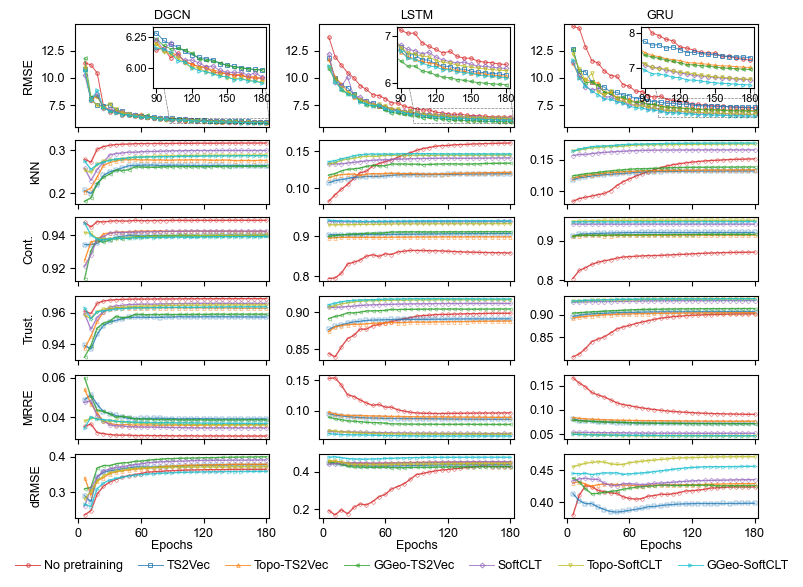

In [39]:
fig, axes = plt.subplots(6,3,figsize=(7.5,5.5), sharex='col', constrained_layout=True, 
                         gridspec_kw={'hspace':0., 'wspace':0., 'height_ratios':[1.6,1,1,1,1,1]})

models = ['original','ts2vec','topo-ts2vec','ggeo-ts2vec','softclt','topo-softclt','ggeo-softclt']
model_types = ['No pretraining', 'TS2Vec', 'Topo-TS2Vec', 'GGeo-TS2Vec', 'SoftCLT', 'Topo-SoftCLT', 'GGeo-SoftCLT']
# colors = plt.cm.Set1(np.linspace(0, 0.77, 7))[[0,4,6,3,5,1,2]]
colors = plt.cm.tab20([0.325, 0.025, 0.125, 0.225, 0.425, 0.825, 0.925])
markers = ['o', 's', '^', '<', 'D', 'v', '>']

for col, encoder in enumerate(['DGCN','LSTM','GRU']):
    if encoder == 'DGCN':
        eval_ = pd.read_csv(f'../results/evaluation/MacroTraffic_progress_evaluation.csv', index_col=[0])
    else:
        eval_ = pd.read_csv(f'../results/evaluation/Macro{encoder}_progress_evaluation.csv', index_col=[0])

    ylim_list = {'DGCN': [5.83, 6.34], 'LSTM': [5.9, 7.2], 'GRU': [6.4, 8.2]}
    for model, color, model_type, marker in zip(models, colors, model_types, markers):
        selected_var = 'rmse'

        if model == 'original':
            ax_focus = axes[0,col].inset_axes([0.4, 0.38, 0.58, 0.6], 
                                              xlim=(6*14.5, 6*30.5), 
                                              ylim=(ylim_list[encoder][0], ylim_list[encoder][1]))
            ax_focus.tick_params(axis='both', labelsize=8, pad=1)
            # ax_focus.set_yticks([85, 90, 95, 100])
            ax_focus.set_xticks([90, 120, 150, 180])
            rect, lines = axes[0,col].indicate_inset_zoom(ax_focus, edgecolor='k')
            for line in lines:
                line.set_color('k')
                line.set_linestyle('--')
                line.set_linewidth(0.5)
            rect.set_edgecolor('k')
            rect.set_linestyle('--')
            rect.set_linewidth(0.5)
        ax_focus.plot(6*(eval_.loc[model]['epoch']+1), eval_.loc[model][selected_var], label=model_type, alpha=0.8,
                        lw=0.7, color=color, marker=marker, markersize=2.5, markerfacecolor='none', markeredgewidth=0.7)
        for row, var in zip([0, 1, 2, 3, 4, 5], [selected_var]+global_dist_metrics):
            if row==0:
                axes[row, col].plot(6*(eval_.loc[model]['epoch']+1), eval_.loc[model][var], label=model_type, alpha=0.8, color=color,
                                    lw=0.7, marker=marker, markersize=2.5, markerfacecolor='none', markeredgewidth=0.7)
            else:
                axes[row, col].plot(6*(eval_.loc[model]['epoch']+1), eval_.loc[model][var], color=color,
                                    lw=1, alpha=0.8)
                axes[row, col].plot(6*(eval_.loc[model]['epoch']+1), eval_.loc[model][var], color=color,
                                    lw=0., marker=marker, markersize=2.5, markerfacecolor='none', markeredgewidth=0.3)
    
    axes[0, col].set_title(encoder, fontsize=9, pad=4)
    axes[0, col].set_ylim(5.5, 14.9)
    axes[-1, col].set_xlabel('Epochs', labelpad=0)
    axes[-1, col].set_xlim(-3, 183)
    axes[-1, col].set_xticks([0, 60, 120, 180])

for row, ylabel in zip(range(6), ['RMSE', 'kNN', 'Cont.', 'Trust.', 'MRRE', 'dRMSE']):
    axes[row, 0].set_ylabel(ylabel)

handles, labels = axes[0, 1].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center', ncol=7, fontsize=9,
           frameon=False, bbox_to_anchor=(0.51, -0.05),
           handletextpad=0.3, columnspacing=1.2)

In [40]:
fig.savefig('macro_traffic_progress.pdf', bbox_inches='tight', dpi=600)

## Discussion

In [53]:
eval_uea = pd.read_csv(f'../results/evaluation/UEA_evaluation.csv', index_col=[0, 1])
eval_uea = eval_uea.rename(index={'ts2vec':'TS2Vec', 'topo-ts2vec':'Topo-TS2Vec', 'ggeo-ts2vec':'GGeo-TS2Vec', 
                                  'softclt':'SoftCLT', 'topo-softclt':'Topo-SoftCLT', 'ggeo-softclt':'GGeo-SoftCLT'})
eval_uea['svm_acc'] = np.round(eval_uea['svm_acc'], 3)
dim_uea = pd.read_csv(f'../datasets/UEA_DataDimensions.csv', index_col=0).set_index('Problem')

ts2vec_wins = dict()
softclt_wins = dict()
ties = dict()
for dataset in eval_uea.index.get_level_values(1).unique():
    eval_dataset = eval_uea.loc[(slice(None), dataset), :].reset_index(level=1, drop=True)
    ts2vec_best = eval_dataset.loc[['TS2Vec','Topo-TS2Vec','GGeo-TS2Vec']]['svm_acc'].idxmax()
    softclt_best = eval_dataset.loc[['SoftCLT','Topo-SoftCLT','GGeo-SoftCLT']]['svm_acc'].idxmax()
    if eval_dataset.loc[ts2vec_best, 'svm_acc']>eval_dataset.loc[softclt_best, 'svm_acc']:
        ts2vec_wins[dataset] = dim_uea.loc[dataset, 'NumClasses']
    elif eval_dataset.loc[ts2vec_best, 'svm_acc']<eval_dataset.loc[softclt_best, 'svm_acc']:
        softclt_wins[dataset] = dim_uea.loc[dataset, 'NumClasses']
    else:
        ties[dataset] = dim_uea.loc[dataset, 'NumClasses']

ts2vec_wins = pd.Series(ts2vec_wins).sort_values()
softclt_wins = pd.Series(softclt_wins).sort_values()
ties = pd.Series(ties).sort_values()

Text(0.5, 0, 'Number of classes')

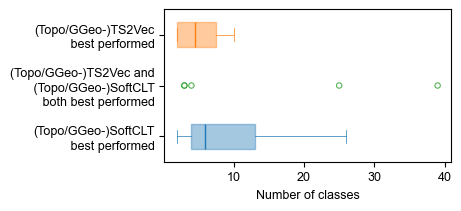

In [72]:
fig, ax = plt.subplots(figsize=(4.5,2), constrained_layout=True)
_ = ax.boxplot([softclt_wins], positions=[1],
           vert=False, widths=0.5, patch_artist=True, showfliers=True, showmeans=False, meanline=False,
           boxprops=dict(facecolor='tab:blue', color='tab:blue', linewidth=1, alpha=0.4),
           whiskerprops=dict(color='tab:blue', linewidth=0.5),
           capprops=dict(color='tab:blue', linewidth=0.5),
           medianprops=dict(color='tab:blue', linewidth=1),
           )
_ = ax.boxplot([ts2vec_wins], positions=[3],
              vert=False, widths=0.5, patch_artist=True, showfliers=True, showmeans=False, meanline=False,
              boxprops=dict(facecolor='tab:orange', color='tab:orange', linewidth=1, alpha=0.4),
              whiskerprops=dict(color='tab:orange', linewidth=0.5),
              capprops=dict(color='tab:orange', linewidth=0.5),
              medianprops=dict(color='tab:orange', linewidth=1),
              )
_ = ax.scatter(ties, [2]*len(ties), color='tab:green', marker='o', s=15, alpha=0.8, facecolors='none', linewidths=0.8)

ax.set_yticks([1,2,3])
ax.set_yticklabels(['(Topo/GGeo-)SoftCLT\n best performed', 
                    '(Topo/GGeo-)TS2Vec and\n (Topo/GGeo-)SoftCLT\n both best performed',
                    '(Topo/GGeo-)TS2Vec\n best performed'])
ax.set_xlabel('Number of classes')

In [73]:
fig.savefig('uea_num_classes.pdf', bbox_inches='tight', dpi=600)

## Detailed results of UEA

In [44]:
model_types = ['TS2Vec', 'Topo-TS2Vec', 'GGeo-TS2Vec', 'SoftCLT', 'Topo-SoftCLT', 'GGeo-SoftCLT']

### Classification accuracy spatial datasets

In [45]:
eval_uea = pd.read_csv(f'../results/evaluation/UEA_evaluation.csv', index_col=[0, 1])
eval_uea = eval_uea.rename(index={'ts2vec':'TS2Vec', 'topo-ts2vec':'Topo-TS2Vec', 'ggeo-ts2vec':'GGeo-TS2Vec', 
                                  'softclt':'SoftCLT', 'topo-softclt':'Topo-SoftCLT', 'ggeo-softclt':'GGeo-SoftCLT'})

detailed_uea = eval_uea[eval_uea.index.get_level_values(1).isin(spatial_datasets)].copy()
detailed_uea = detailed_uea.reset_index().pivot(index='dataset', columns='model', values='svm_acc')
detailed_uea = detailed_uea.T.loc[model_types].T.sort_index()
detailed_uea.loc['Avg. over spatial datasets'] = detailed_uea.mean(axis=0)
detailed_uea = highlight(detailed_uea.T, 
                         max_cols=detailed_uea.T.columns,
                         involve_second=False).T 
print(detailed_uea.to_latex())
detailed_uea

\begin{tabular}{lllllll}
\toprule
model & TS2Vec & Topo-TS2Vec & GGeo-TS2Vec & SoftCLT & Topo-SoftCLT & GGeo-SoftCLT \\
dataset &  &  &  &  &  &  \\
\midrule
ArticularyWordRecognition & 0.980 & \textbf{\underline{0.987}} & 0.983 & \textbf{\underline{0.987}} & 0.977 & \textbf{\underline{0.987}} \\
BasicMotions & \textbf{\underline{1.000}} & \textbf{\underline{1.000}} & \textbf{\underline{1.000}} & \textbf{\underline{1.000}} & \textbf{\underline{1.000}} & \textbf{\underline{1.000}} \\
CharacterTrajectories & 0.971 & 0.985 & 0.972 & 0.980 & 0.977 & \textbf{\underline{0.986}} \\
Cricket & 0.944 & 0.944 & 0.972 & 0.972 & 0.972 & \textbf{\underline{0.986}} \\
ERing & 0.867 & 0.874 & 0.881 & \textbf{\underline{0.893}} & 0.878 & 0.863 \\
EigenWorms & 0.809 & 0.817 & 0.863 & 0.817 & \textbf{\underline{0.901}} & 0.840 \\
Epilepsy & 0.957 & 0.957 & 0.949 & \textbf{\underline{0.964}} & 0.957 & 0.949 \\
Handwriting & 0.498 & 0.499 & 0.479 & 0.487 & 0.478 & \textbf{\underline{0.580}} \\
LSST & 0.485

model,TS2Vec,Topo-TS2Vec,GGeo-TS2Vec,SoftCLT,Topo-SoftCLT,GGeo-SoftCLT
dataset,,,,,,
ArticularyWordRecognition,0.980,\textbf{\underline{0.987}},0.983,\textbf{\underline{0.987}},0.977,\textbf{\underline{0.987}}
BasicMotions,\textbf{\underline{1.000}},\textbf{\underline{1.000}},\textbf{\underline{1.000}},\textbf{\underline{1.000}},\textbf{\underline{1.000}},\textbf{\underline{1.000}}
CharacterTrajectories,0.971,0.985,0.972,0.980,0.977,\textbf{\underline{0.986}}
Cricket,0.944,0.944,0.972,0.972,0.972,\textbf{\underline{0.986}}
ERing,0.867,0.874,0.881,\textbf{\underline{0.893}},0.878,0.863
EigenWorms,0.809,0.817,0.863,0.817,\textbf{\underline{0.901}},0.840
Epilepsy,0.957,0.957,0.949,\textbf{\underline{0.964}},0.957,0.949
Handwriting,0.498,0.499,0.479,0.487,0.478,\textbf{\underline{0.580}}
LSST,0.485,0.566,0.536,0.452,0.569,\textbf{\underline{0.581}}


### Classification accuracy non-spatial datasets

In [46]:
detailed_uea = eval_uea[eval_uea.index.get_level_values(1).isin(non_spatial_datasets)].copy()
detailed_uea = detailed_uea.reset_index().pivot(index='dataset', columns='model', values='svm_acc')
detailed_uea = detailed_uea.T.loc[model_types].T.sort_index()
detailed_uea.loc['Avg. over non-spatial datasets'] = detailed_uea.mean(axis=0)
detailed_uea = highlight(detailed_uea.T, 
                         max_cols=detailed_uea.T.columns,
                         involve_second=False).T 
print(detailed_uea.to_latex())
detailed_uea

\begin{tabular}{lllllll}
\toprule
model & TS2Vec & Topo-TS2Vec & GGeo-TS2Vec & SoftCLT & Topo-SoftCLT & GGeo-SoftCLT \\
dataset &  &  &  &  &  &  \\
\midrule
AtrialFibrillation & 0.200 & \textbf{\underline{0.267}} & 0.133 & 0.133 & 0.200 & \textbf{\underline{0.267}} \\
DuckDuckGeese & 0.360 & \textbf{\underline{0.540}} & 0.520 & 0.400 & 0.420 & 0.400 \\
EthanolConcentration & 0.289 & 0.274 & 0.297 & 0.243 & \textbf{\underline{0.308}} & \textbf{\underline{0.308}} \\
FaceDetection & 0.510 & 0.508 & 0.505 & \textbf{\underline{0.516}} & 0.497 & 0.505 \\
FingerMovements & 0.480 & 0.480 & 0.480 & 0.530 & 0.470 & \textbf{\underline{0.540}} \\
HandMovementDirection & 0.324 & \textbf{\underline{0.405}} & 0.257 & 0.324 & 0.230 & 0.257 \\
Heartbeat & 0.751 & \textbf{\underline{0.761}} & 0.717 & 0.756 & 0.737 & 0.732 \\
JapaneseVowels & 0.978 & \textbf{\underline{0.986}} & 0.978 & 0.970 & 0.978 & 0.978 \\
MotorImagery & 0.480 & 0.500 & 0.500 & \textbf{\underline{0.520}} & 0.500 & 0.500 \\
PhonemeS

model,TS2Vec,Topo-TS2Vec,GGeo-TS2Vec,SoftCLT,Topo-SoftCLT,GGeo-SoftCLT
dataset,,,,,,
AtrialFibrillation,0.200,\textbf{\underline{0.267}},0.133,0.133,0.200,\textbf{\underline{0.267}}
DuckDuckGeese,0.360,\textbf{\underline{0.540}},0.520,0.400,0.420,0.400
EthanolConcentration,0.289,0.274,0.297,0.243,\textbf{\underline{0.308}},\textbf{\underline{0.308}}
FaceDetection,0.510,0.508,0.505,\textbf{\underline{0.516}},0.497,0.505
FingerMovements,0.480,0.480,0.480,0.530,0.470,\textbf{\underline{0.540}}
HandMovementDirection,0.324,\textbf{\underline{0.405}},0.257,0.324,0.230,0.257
Heartbeat,0.751,\textbf{\underline{0.761}},0.717,0.756,0.737,0.732
JapaneseVowels,0.978,\textbf{\underline{0.986}},0.978,0.970,0.978,0.978
MotorImagery,0.480,0.500,0.500,\textbf{\underline{0.520}},0.500,0.500


### Training time spatial datasets

In [47]:
eval_uea = pd.read_csv(f'../results/evaluation/UEA_training_efficiency.csv', index_col=[0, 1])
eval_uea = eval_uea.rename(index={'ts2vec':'TS2Vec', 'topo-ts2vec':'Topo-TS2Vec', 'ggeo-ts2vec':'GGeo-TS2Vec', 
                                  'softclt':'SoftCLT', 'topo-softclt':'Topo-SoftCLT', 'ggeo-softclt':'GGeo-SoftCLT'})

detailed_uea = eval_uea[eval_uea.index.get_level_values(1).isin(spatial_datasets)].copy()
detailed_uea['train_time_per_epoch'] = detailed_uea['training_time']/detailed_uea['training_epochs']
detailed_uea = detailed_uea.reset_index().pivot(index='dataset', columns='model', values='train_time_per_epoch')
detailed_uea = detailed_uea.T.loc[model_types].T.sort_index()
detailed_uea.loc['Avg. over spatial datasets'] = detailed_uea.mean(axis=0)
detailed_uea = highlight(detailed_uea.T).T

avg_multipliers = []
for model in model_types:
    if model=='TS2Vec':
        baselines = detailed_uea[model].values
        detailed_uea[model] = detailed_uea[model].astype(str) + ' (1.00$\\times$)'
    else:
        values = detailed_uea[model].values
        detailed_uea[model] = [f'{v} ({v/b:.2f}$\\times$)' for v, b in zip(values.astype(float), baselines.astype(float))]
        avg_multipliers.append(np.mean(values.astype(float)/baselines.astype(float)))
avg_baseline = baselines.astype(float).mean()

detailed_uea.loc['Avg. over spatial datasets', 'TS2Vec'] = avg_baseline
detailed_uea.loc['Avg. over spatial datasets', model_types[1:]] = [f'{v:.2f}$\\times$' for v in avg_multipliers]

print(detailed_uea.to_latex())
detailed_uea

\begin{tabular}{lllllll}
\toprule
model & TS2Vec & Topo-TS2Vec & GGeo-TS2Vec & SoftCLT & Topo-SoftCLT & GGeo-SoftCLT \\
dataset &  &  &  &  &  &  \\
\midrule
ArticularyWordRecognition & 3.799 (1.00$\times$) & 5.61 (1.48$\times$) & 5.863 (1.54$\times$) & 3.772 (0.99$\times$) & 5.77 (1.52$\times$) & 5.983 (1.57$\times$) \\
BasicMotions & 0.475 (1.00$\times$) & 0.685 (1.44$\times$) & 0.709 (1.49$\times$) & 0.457 (0.96$\times$) & 0.687 (1.45$\times$) & 0.711 (1.50$\times$) \\
CharacterTrajectories & 20.640 (1.00$\times$) & 30.863 (1.50$\times$) & 33.32 (1.61$\times$) & 20.652 (1.00$\times$) & 30.948 (1.50$\times$) & 33.18 (1.61$\times$) \\
Cricket & 1.903 (1.00$\times$) & 2.653 (1.39$\times$) & 5.437 (2.86$\times$) & 1.904 (1.00$\times$) & 2.655 (1.40$\times$) & 5.436 (2.86$\times$) \\
ERing & 0.319 (1.00$\times$) & 0.482 (1.51$\times$) & 0.487 (1.53$\times$) & 0.316 (0.99$\times$) & 0.483 (1.51$\times$) & 0.49 (1.54$\times$) \\
EigenWorms & 19.862 (1.00$\times$) & 23.823 (1.20$\times$) & 

model,TS2Vec,Topo-TS2Vec,GGeo-TS2Vec,SoftCLT,Topo-SoftCLT,GGeo-SoftCLT
dataset,,,,,,
ArticularyWordRecognition,3.799 (1.00$\times$),5.61 (1.48$\times$),5.863 (1.54$\times$),3.772 (0.99$\times$),5.77 (1.52$\times$),5.983 (1.57$\times$)
BasicMotions,0.475 (1.00$\times$),0.685 (1.44$\times$),0.709 (1.49$\times$),0.457 (0.96$\times$),0.687 (1.45$\times$),0.711 (1.50$\times$)
CharacterTrajectories,20.640 (1.00$\times$),30.863 (1.50$\times$),33.32 (1.61$\times$),20.652 (1.00$\times$),30.948 (1.50$\times$),33.18 (1.61$\times$)
Cricket,1.903 (1.00$\times$),2.653 (1.39$\times$),5.437 (2.86$\times$),1.904 (1.00$\times$),2.655 (1.40$\times$),5.436 (2.86$\times$)
ERing,0.319 (1.00$\times$),0.482 (1.51$\times$),0.487 (1.53$\times$),0.316 (0.99$\times$),0.483 (1.51$\times$),0.49 (1.54$\times$)
EigenWorms,19.862 (1.00$\times$),23.823 (1.20$\times$),149.05 (7.50$\times$),20.224 (1.02$\times$),24.856 (1.25$\times$),150.7 (7.59$\times$)
Epilepsy,1.737 (1.00$\times$),2.49 (1.43$\times$),2.753 (1.58$\times$),1.686 (0.97$\times$),2.506 (1.44$\times$),2.755 (1.59$\times$)
Handwriting,1.875 (1.00$\times$),2.771 (1.48$\times$),2.959 (1.58$\times$),1.88 (1.00$\times$),2.775 (1.48$\times$),2.987 (1.59$\times$)
LSST,29.786 (1.00$\times$),45.273 (1.52$\times$),45.162 (1.52$\times$),29.859 (1.00$\times$),45.216 (1.52$\times$),45.154 (1.52$\times$)


### Training time non-spatial datasets

In [48]:
detailed_uea = eval_uea[eval_uea.index.get_level_values(1).isin(non_spatial_datasets)].copy()
detailed_uea['train_time_per_epoch'] = detailed_uea['training_time']/detailed_uea['training_epochs']
detailed_uea = detailed_uea.reset_index().pivot(index='dataset', columns='model', values='train_time_per_epoch')
detailed_uea = detailed_uea.T.loc[model_types].T.sort_index()
detailed_uea.loc['Avg. over non-spatial datasets'] = detailed_uea.mean(axis=0)
detailed_uea = highlight(detailed_uea.T).T

avg_multipliers = []
for model in model_types:
    if model=='TS2Vec':
        baselines = detailed_uea[model].values
        detailed_uea[model] = detailed_uea[model].astype(str) + ' (1.00$\\times$)'
    else:
        values = detailed_uea[model].values
        detailed_uea[model] = [f'{v} ({v/b:.2f}$\\times$)' for v, b in zip(values.astype(float), baselines.astype(float))]
        avg_multipliers.append(np.mean(values.astype(float)/baselines.astype(float)))
avg_baseline = baselines.astype(float).mean()

detailed_uea.loc['Avg. over non-spatial datasets', 'TS2Vec'] = avg_baseline
detailed_uea.loc['Avg. over non-spatial datasets', model_types[1:]] = [f'{v:.2f}$\\times$' for v in avg_multipliers]

print(detailed_uea.to_latex())
detailed_uea

\begin{tabular}{lllllll}
\toprule
model & TS2Vec & Topo-TS2Vec & GGeo-TS2Vec & SoftCLT & Topo-SoftCLT & GGeo-SoftCLT \\
dataset &  &  &  &  &  &  \\
\midrule
AtrialFibrillation & 0.182 (1.00$\times$) & 0.258 (1.42$\times$) & 0.369 (2.03$\times$) & 0.177 (0.97$\times$) & 0.259 (1.42$\times$) & 0.366 (2.01$\times$) \\
DuckDuckGeese & 0.617 (1.00$\times$) & 0.973 (1.58$\times$) & 1.059 (1.72$\times$) & 0.621 (1.01$\times$) & 0.968 (1.57$\times$) & 1.104 (1.79$\times$) \\
EthanolConcentration & 4.939 (1.00$\times$) & 6.655 (1.35$\times$) & 20.128 (4.08$\times$) & 4.89 (0.99$\times$) & 6.664 (1.35$\times$) & 20.182 (4.09$\times$) \\
FaceDetection & 70.709 (1.00$\times$) & 109.6 (1.55$\times$) & 108.83 (1.54$\times$) & 71.104 (1.01$\times$) & 107.523 (1.52$\times$) & 107.092 (1.51$\times$) \\
FingerMovements & 3.826 (1.00$\times$) & 5.67 (1.48$\times$) & 5.706 (1.49$\times$) & 3.779 (0.99$\times$) & 5.671 (1.48$\times$) & 5.716 (1.49$\times$) \\
HandMovementDirection & 2.221 (1.00$\times$) &

model,TS2Vec,Topo-TS2Vec,GGeo-TS2Vec,SoftCLT,Topo-SoftCLT,GGeo-SoftCLT
dataset,,,,,,
AtrialFibrillation,0.182 (1.00$\times$),0.258 (1.42$\times$),0.369 (2.03$\times$),0.177 (0.97$\times$),0.259 (1.42$\times$),0.366 (2.01$\times$)
DuckDuckGeese,0.617 (1.00$\times$),0.973 (1.58$\times$),1.059 (1.72$\times$),0.621 (1.01$\times$),0.968 (1.57$\times$),1.104 (1.79$\times$)
EthanolConcentration,4.939 (1.00$\times$),6.655 (1.35$\times$),20.128 (4.08$\times$),4.89 (0.99$\times$),6.664 (1.35$\times$),20.182 (4.09$\times$)
FaceDetection,70.709 (1.00$\times$),109.6 (1.55$\times$),108.83 (1.54$\times$),71.104 (1.01$\times$),107.523 (1.52$\times$),107.092 (1.51$\times$)
FingerMovements,3.826 (1.00$\times$),5.67 (1.48$\times$),5.706 (1.49$\times$),3.779 (0.99$\times$),5.671 (1.48$\times$),5.716 (1.49$\times$)
HandMovementDirection,2.221 (1.00$\times$),3.353 (1.51$\times$),4.151 (1.87$\times$),2.226 (1.00$\times$),3.334 (1.50$\times$),4.142 (1.86$\times$)
Heartbeat,2.811 (1.00$\times$),4.218 (1.50$\times$),5.22 (1.86$\times$),2.818 (1.00$\times$),4.216 (1.50$\times$),5.221 (1.86$\times$)
JapaneseVowels,3.211 (1.00$\times$),4.871 (1.52$\times$),4.821 (1.50$\times$),3.199 (1.00$\times$),4.846 (1.51$\times$),4.83 (1.50$\times$)
MotorImagery,7.450 (1.00$\times$),9.637 (1.29$\times$),51.0 (6.85$\times$),7.475 (1.00$\times$),9.659 (1.30$\times$),50.881 (6.83$\times$)


## LSTM and GRU evaluation

In [49]:
macro_prediction_metrics = ['mae', 'rmse', 'error_std', 'explained_variance']
dist_metrics = ['mean_shared_neighbours','mean_continuity','mean_trustworthiness','mean_dist_mrre','distmat_rmse']
model_types = ['No pretraining', 'TS2Vec', 'Topo-TS2Vec', 'GGeo-TS2Vec', 'SoftCLT', 'Topo-SoftCLT', 'GGeo-SoftCLT']

### Task-specific metrics

In [50]:
eval_lstm_continued = []
lstm_progress = pd.read_csv(f'../results/evaluation/MacroLSTM_progress_evaluation.csv', index_col=[0])
for model in ['original','ts2vec','softclt','topo-ts2vec','ggeo-ts2vec','topo-softclt','ggeo-softclt']:
    eval_lstm_continued.append((lstm_progress.loc[model].iloc[[-1]]+lstm_progress.loc[model].iloc[[-2]])/2)
eval_lstm_continued = pd.concat(eval_lstm_continued, axis=0)
eval_lstm_continued = eval_lstm_continued.T.iloc[1:].astype(float).T
eval_lstm_continued = eval_lstm_continued.rename(index={'original':'No pretraining', 'ts2vec':'TS2Vec', 'topo-ts2vec':'Topo-TS2Vec', 'ggeo-ts2vec':'GGeo-TS2Vec',
                                                        'softclt':'SoftCLT', 'topo-softclt':'Topo-SoftCLT', 'ggeo-softclt':'GGeo-SoftCLT'})
eval_lstm_continued = eval_lstm_continued.loc[model_types]

eval_gru_continued = []
gru_progress = pd.read_csv(f'../results/evaluation/MacroGRU_progress_evaluation.csv', index_col=[0])
for model in ['original','ts2vec','softclt','topo-ts2vec','ggeo-ts2vec','topo-softclt','ggeo-softclt']:
    eval_gru_continued.append((gru_progress.loc[model].iloc[[-1]]+gru_progress.loc[model].iloc[[-2]])/2)
eval_gru_continued = pd.concat(eval_gru_continued, axis=0)
eval_gru_continued = eval_gru_continued.T.iloc[1:].astype(float).T
eval_gru_continued = eval_gru_continued.rename(index={'original':'No pretraining', 'ts2vec':'TS2Vec', 'topo-ts2vec':'Topo-TS2Vec', 'ggeo-ts2vec':'GGeo-TS2Vec',
                                                      'softclt':'SoftCLT', 'topo-softclt':'Topo-SoftCLT', 'ggeo-softclt':'GGeo-SoftCLT'})
eval_gru_continued = eval_gru_continued.loc[model_types]

In [51]:
styled_traffic = eval_lstm_continued[macro_prediction_metrics].merge(
    eval_gru_continued[macro_prediction_metrics],
    left_index=True, right_index=True,
    suffixes=('_lstm', '_gru'))
styled_traffic['explained_variance_lstm'] = styled_traffic['explained_variance_lstm']*100
styled_traffic['explained_variance_gru'] = styled_traffic['explained_variance_gru']*100

old_best = styled_traffic.loc['No pretraining']
new_best = styled_traffic.min(axis=0)
new_best['explained_variance_lstm'] = styled_traffic['explained_variance_lstm'].max()
new_best['explained_variance_gru'] = styled_traffic['explained_variance_gru'].max()

styled_traffic = highlight(styled_traffic, 
                           max_cols=['explained_variance_lstm', 'explained_variance_gru'],
                           min_cols=['mae_lstm', 'rmse_lstm', 'error_std_lstm', 'mae_gru', 'rmse_gru', 'error_std_gru'])
styled_traffic.loc['Best improvement'] = np.round(abs(new_best - old_best)/(old_best)*100, 3)
styled_traffic = styled_traffic.style.format(decimal='.', thousands=',', precision=3)
print(styled_traffic.to_latex())
styled_traffic

\begin{tabular}{lllllllll}
 & mae_lstm & rmse_lstm & error_std_lstm & explained_variance_lstm & mae_gru & rmse_gru & error_std_gru & explained_variance_gru \\
model &  &  &  &  &  &  &  &  \\
No pretraining & 3.244 & 6.402 & 6.400 & 82.161 & 3.552 & 7.228 & 7.228 & 77.248 \\
TS2Vec & 3.158 & 6.187 & 6.187 & 83.331 & 3.601 & 7.297 & 7.297 & 76.813 \\
Topo-TS2Vec & 3.139 & 6.155 & 6.154 & 83.505 & 3.491 & 7.006 & 7.006 & 78.626 \\
GGeo-TS2Vec & \textbf{\underline{3.101}} & \textbf{\underline{5.974}} & \textbf{\underline{5.973}} & \textbf{\underline{84.461}} & 3.466 & 6.948 & 6.947 & 78.984 \\
SoftCLT & 3.191 & 6.319 & 6.319 & 82.612 & \textbf{3.349} & \textbf{6.649} & \textbf{6.649} & \textbf{80.749} \\
Topo-SoftCLT & 3.192 & 6.271 & 6.270 & 82.877 & 3.367 & 6.661 & 6.660 & 80.682 \\
GGeo-SoftCLT & \textbf{3.128} & \textbf{6.121} & \textbf{6.121} & \textbf{83.683} & \textbf{\underline{3.302}} & \textbf{\underline{6.495}} & \textbf{\underline{6.495}} & \textbf{\underline{81.630}} \\
Best 

,mae_lstm,rmse_lstm,error_std_lstm,explained_variance_lstm,mae_gru,rmse_gru,error_std_gru,explained_variance_gru
model,,,,,,,,
No pretraining,3.244,6.402,6.400,82.161,3.552,7.228,7.228,77.248
TS2Vec,3.158,6.187,6.187,83.331,3.601,7.297,7.297,76.813
Topo-TS2Vec,3.139,6.155,6.154,83.505,3.491,7.006,7.006,78.626
GGeo-TS2Vec,\textbf{\underline{3.101}},\textbf{\underline{5.974}},\textbf{\underline{5.973}},\textbf{\underline{84.461}},3.466,6.948,6.947,78.984
SoftCLT,3.191,6.319,6.319,82.612,\textbf{3.349},\textbf{6.649},\textbf{6.649},\textbf{80.749}
Topo-SoftCLT,3.192,6.271,6.270,82.877,3.367,6.661,6.660,80.682
GGeo-SoftCLT,\textbf{3.128},\textbf{6.121},\textbf{6.121},\textbf{83.683},\textbf{\underline{3.302}},\textbf{\underline{6.495}},\textbf{\underline{6.495}},\textbf{\underline{81.630}}
Best improvement,4.415,6.676,6.668,2.799,7.026,10.141,10.145,5.673


### Global structure preservation metrics

In [52]:
styled_traffic = eval_lstm_continued[['global_'+metric for metric in dist_metrics]].merge(
    eval_gru_continued[['global_'+metric for metric in dist_metrics]],
    left_index=True, right_index=True, suffixes=('_lstm', '_gru'))
styled_traffic = highlight(styled_traffic,
                       min_cols=['global_'+metric+'_lstm' for metric in dist_metrics[3:]]+['global_'+metric+'_gru' for metric in dist_metrics[3:]],
                       max_cols=['global_'+metric+'_lstm' for metric in dist_metrics[:3]]+['global_'+metric+'_gru' for metric in dist_metrics[:3]])
print(styled_traffic.to_latex())
styled_traffic

\begin{tabular}{lllllllllll}
\toprule
 & global_mean_shared_neighbours_lstm & global_mean_continuity_lstm & global_mean_trustworthiness_lstm & global_mean_dist_mrre_lstm & global_distmat_rmse_lstm & global_mean_shared_neighbours_gru & global_mean_continuity_gru & global_mean_trustworthiness_gru & global_mean_dist_mrre_gru & global_distmat_rmse_gru \\
model &  &  &  &  &  &  &  &  &  &  \\
\midrule
No pretraining & \textbf{\underline{0.161}} & 0.858 & 0.899 & 0.097 & \textbf{\underline{0.427}} & 0.151 & 0.870 & 0.902 & 0.091 & \textbf{0.424} \\
TS2Vec & 0.120 & 0.907 & 0.891 & 0.086 & 0.437 & 0.132 & 0.921 & 0.906 & 0.072 & \textbf{\underline{0.399}} \\
Topo-TS2Vec & 0.122 & 0.899 & 0.888 & 0.089 & 0.452 & 0.134 & 0.914 & 0.904 & 0.076 & 0.429 \\
GGeo-TS2Vec & 0.134 & 0.912 & 0.905 & 0.078 & \textbf{\underline{0.427}} & 0.138 & 0.916 & 0.913 & 0.071 & 0.426 \\
SoftCLT & 0.141 & \textbf{0.938} & 0.912 & 0.063 & 0.453 & 0.166 & 0.942 & 0.931 & 0.052 & 0.435 \\
Topo-SoftCLT & 0.145 & 0.932

,global_mean_shared_neighbours_lstm,global_mean_continuity_lstm,global_mean_trustworthiness_lstm,global_mean_dist_mrre_lstm,global_distmat_rmse_lstm,global_mean_shared_neighbours_gru,global_mean_continuity_gru,global_mean_trustworthiness_gru,global_mean_dist_mrre_gru,global_distmat_rmse_gru
model,,,,,,,,,,
No pretraining,\textbf{\underline{0.161}},0.858,0.899,0.097,\textbf{\underline{0.427}},0.151,0.870,0.902,0.091,\textbf{0.424}
TS2Vec,0.120,0.907,0.891,0.086,0.437,0.132,0.921,0.906,0.072,\textbf{\underline{0.399}}
Topo-TS2Vec,0.122,0.899,0.888,0.089,0.452,0.134,0.914,0.904,0.076,0.429
GGeo-TS2Vec,0.134,0.912,0.905,0.078,\textbf{\underline{0.427}},0.138,0.916,0.913,0.071,0.426
SoftCLT,0.141,\textbf{0.938},0.912,0.063,0.453,0.166,0.942,0.931,0.052,0.435
Topo-SoftCLT,0.145,0.932,\textbf{0.917},\textbf{0.061},0.444,\textbf{0.175},\textbf{\underline{0.951}},\textbf{0.934},\textbf{\underline{0.046}},0.471
GGeo-SoftCLT,\textbf{0.147},\textbf{\underline{0.940}},\textbf{\underline{0.918}},\textbf{\underline{0.059}},0.477,\textbf{\underline{0.177}},\textbf{0.948},\textbf{\underline{0.935}},\textbf{\underline{0.046}},0.456


## TSNE visualization

### Epilepsy dataset

100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


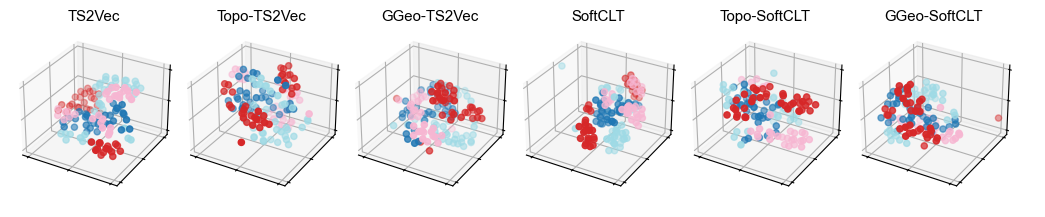

In [8]:
loader = 'UEA'
dataset = 'Epilepsy'
model_names = ['ts2vec', 'topo-ts2vec', 'ggeo-ts2vec', 'softclt', 'topo-softclt', 'ggeo-softclt']
model_types = ['TS2Vec', 'Topo-TS2Vec', 'GGeo-TS2Vec', 'SoftCLT', 'Topo-SoftCLT', 'GGeo-SoftCLT']

fig = plt.figure(figsize=(13., 3.))
for ax_id, model_name in tqdm(enumerate(model_names), total=len(model_types)):
    latents = np.load(f'../results/pretrain/{loader}/{model_name}/{dataset}/latents_global.npz')
    labels = latents['labels']
    latents = latents['latents']

    reducer = TSNE(n_components=3, random_state=131, perplexity=15, learning_rate='auto')
    latents_3d = reducer.fit_transform(latents)
    latents_3d = (latents_3d - np.min(latents_3d, axis=0)) / (np.max(latents_3d, axis=0) - np.min(latents_3d, axis=0))

    ax = fig.add_subplot(1, len(model_types), ax_id+1, projection='3d')
    ax.scatter(latents_3d[:, 0], latents_3d[:, 1], latents_3d[:, 2], c=labels, cmap='tab20')

    ax.set_title(model_types[ax_id])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
fig.savefig('Epilepsy_latents.pdf', bbox_inches='tight', dpi=600)

### RacketSports dataset

100%|██████████| 6/6 [00:20<00:00,  3.44s/it]


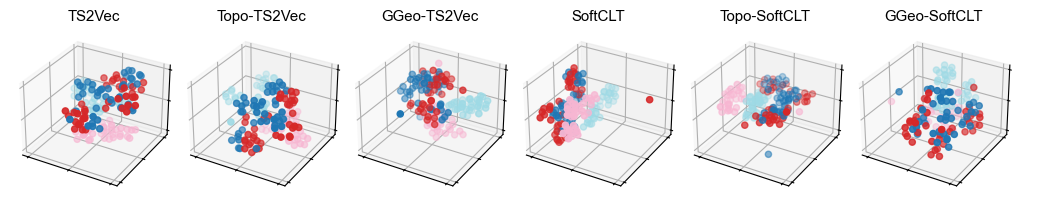

In [10]:
loader = 'UEA'
dataset = 'RacketSports'
model_names = ['ts2vec', 'topo-ts2vec', 'ggeo-ts2vec', 'softclt', 'topo-softclt', 'ggeo-softclt']
model_types = ['TS2Vec', 'Topo-TS2Vec', 'GGeo-TS2Vec', 'SoftCLT', 'Topo-SoftCLT', 'GGeo-SoftCLT']

fig = plt.figure(figsize=(13., 3.))
for ax_id, model_name in tqdm(enumerate(model_names), total=len(model_types)):
    latents = np.load(f'../results/pretrain/{loader}/{model_name}/{dataset}/latents_global.npz')
    labels = latents['labels']
    latents = latents['latents']

    reducer = TSNE(n_components=3, random_state=131, perplexity=17, learning_rate='auto')
    latents_3d = reducer.fit_transform(latents)
    latents_3d = (latents_3d - np.min(latents_3d, axis=0)) / (np.max(latents_3d, axis=0) - np.min(latents_3d, axis=0))

    ax = fig.add_subplot(1, len(model_types), ax_id+1, projection='3d')
    ax.scatter(latents_3d[:, 0], latents_3d[:, 1], latents_3d[:, 2], c=labels, cmap='tab20')

    ax.set_title(model_types[ax_id])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
fig.savefig('RacketSports_latents.pdf', bbox_inches='tight', dpi=600)